# Случайный лес

Цель этого ноутбука &mdash; знакомство со случайными лесами, с их параметрами и свойствами.

In [6]:
import copy
import random
import warnings

import numpy as np
import pandas as pd
import scipy.stats as sps

from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split

warnings.simplefilter("ignore", DeprecationWarning)
sns.set(context='poster')
%matplotlib inline

np.random.seed(42)

### Основные параметры

**Реализации: `RandomForestClassifier`, `RandomForestRegressor`**

Набор гиперпараметров случайного леса очень похож на набор гиперпараметров решающего дерева. Основным отличием является наличие у случайного леса параметра `n_estimators`, задающего количество решающих деревьев, используемых для получения предсказаний. Это **основной гиперпараметр** для случайного леса.

Напомним главные гиперпараметры решающего дерева, которые также имеются у случайного леса.

* `criterion` — критерий информативности, по которому происходит разбиение вершины дерева. 

* `max_depth` — ограничение на глубину каждого дерева в лесе.

* `min_samples_split` — минимальное количество элементов обучающей выборки в вершине дерева, чтобы её можно было разбивать.

* `min_samples_leaf` — минимальное количество элементов обучающей выборке в листовой вершине.

* `splitter` — способ разбиения вершины каждого решающего дерева. Есть 2 возможных варианта: `best` и `random`. В первом случае рассматриваются все возможные способы разбить вершину дерева на две и берётся тот из них, значение критерия для которого оптимально. При `splitter=random` берётся несколько случайных возможных разбиений и среди них выбирается то, значение критерия для которого оптимально.

* `max_features` — максимальное количество признаков, которые могут быть перебраны при разбиении вершины дерева. Перед каждым разбиением дерева генерируется выборка из `min(k, max_features)` случайных признаков (`k` — количество признаков в датасете) и только эти признаки рассматриваются как разделяющие в данной вершине. <br>
Этот признак может принимать 
    * целочисленное значение — число признаков, 
    * вещественное значение — доля признаков, 
    * `None` — все признаки, 
    * `"auto"` — квадратный корень от числа всех признаков (по умолчанию), 
    * `"sqrt"` — квадратный корень от числа всех признаков, 
    * `"log2"` — двоичный логарифм от числа всех признаков.
    
* `min_impurity_decrease` — минимальное значение уменьшения взвешенного критерия неопределенности (`impurity`), чтобы можно было разбить выборку в данной вершине.

О других гиперпараметрах случайного леса можно почитать в <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html">документации</a>.

## Решение задачи классификации с помощью Random Forest

Возьмем классический датасет Breast Canser для определения доброкачественной или злокачественной опухоли. Его можно скачать с помощью `sklearn`, а дополнительную информацию о переменных можно почитать <a href="https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+dicancer = load_breast_cancer()
X, y = cancer.data, cancer.targetagnostic">тут</a>. 

In [13]:
cancer = load_breast_cancer()
X, y = cancer['data'], cancer['target']

### Зависимость точности классификации от значений гиперпараметров

Разобьём данные на обучающую и тестовую выборки.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Для начала попробуем оценить оптимальное количество решающих деревьев в лесе, взяв значения всех остальных параметров по умолчанию. Построим график зависимости `accuracy` от `n_estimators` на обучающей и на тестовой выборках. В большинстве случаев, значение `n_estimators` берут в диапазоне от 10 до 100. Но здесь мы рассмотрим более широкий набор значений — от 1 до 200.

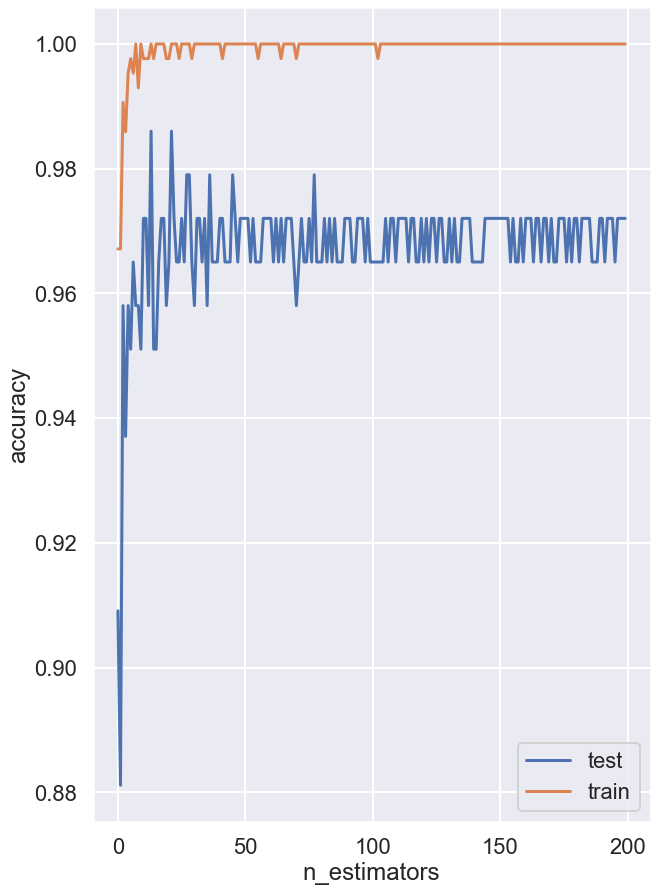

In [20]:
plt.figure(figsize=(10, 15))

accuracy_test = []
accuracy_train = []

for n_estimators in range(1, 201):
    model = RandomForestClassifier(n_estimators=n_estimators)
    model.fit(X_train, y_train)
    predictions_train = model.predict(X_train) 
    predictions_test = model.predict(X_test) 
    accuracy_train.append(accuracy_score(predictions_train, y_train))
    accuracy_test.append(accuracy_score(predictions_test, y_test))

plt.plot(accuracy_test, label='test')
plt.plot(accuracy_train, label='train')
plt.legend()
plt.xlabel('n_estimators'), plt.ylabel('accuracy')
plt.show()

**Выводы:** на тесте точность меньше, на трейне с некоторого значения точность единица, переобучение; значение метрики сначала растет, с некоторого значения количества деревьев (25) выходит на константу

В теории, при предположении, что все решающие деревья в лесе независимы между собой, должно получаться, что при увеличении числа случайных решающих деревьев в лесе дисперсия предсказания монотонно снижается, а точность монотонно повышается. Однако из-за того, что на практике решающие деревья попарно скоррелированны, такой эффект наблюдается лишь до некоторого значения `n_estimators`, а затем значительных изменений не происходит.

Определите из графика оптимальное значение `n_estimators` и используйте это значение во всех последующих экспериментах с данным датасетом. Построим график зависимости `accuracy` от `min_samples_leaf` на обучающей и на тестовой выборках.

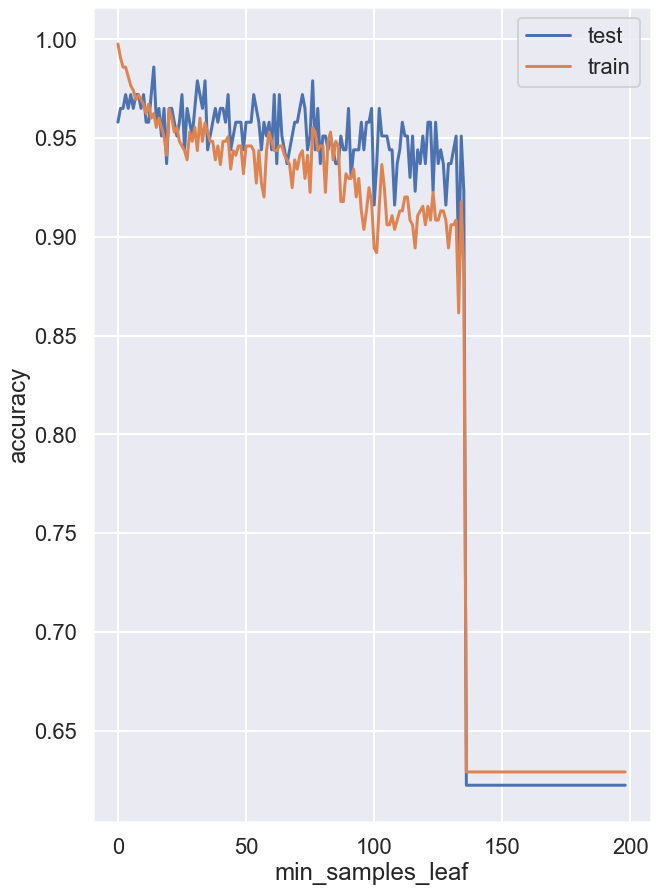

In [22]:
n_estimators = 25
plt.figure(figsize=(10, 15))

accuracy_test = []
accuracy_train = []

for min_samples_leaf in range(1, 200):
    model = RandomForestClassifier(n_estimators=n_estimators, min_samples_leaf=min_samples_leaf)
    model.fit(X_train, y_train)
    predictions_train = model.predict(X_train) 
    predictions_test = model.predict(X_test) 
    accuracy_train.append(accuracy_score(predictions_train, y_train))
    accuracy_test.append(accuracy_score(predictions_test, y_test))

plt.plot(accuracy_test, label='test')
plt.plot(accuracy_train, label='train')
plt.legend()
plt.xlabel('min_samples_leaf'), plt.ylabel('accuracy')
plt.show()

**Выводы:** есть область с маленьким min_samples_leaf, где трейн гораздо точнее, есть область с резким снижением со значением min_samples_leaf составляющим значительню часть исходной выборки, и это ограничение на листья мешает дереву делить узлы, дерево становится неинформативным, между этими областями трейн и тест показывают похожие значения метрики.

Теперь повторим повторим эксперимент для параметра `min_samples_split`.

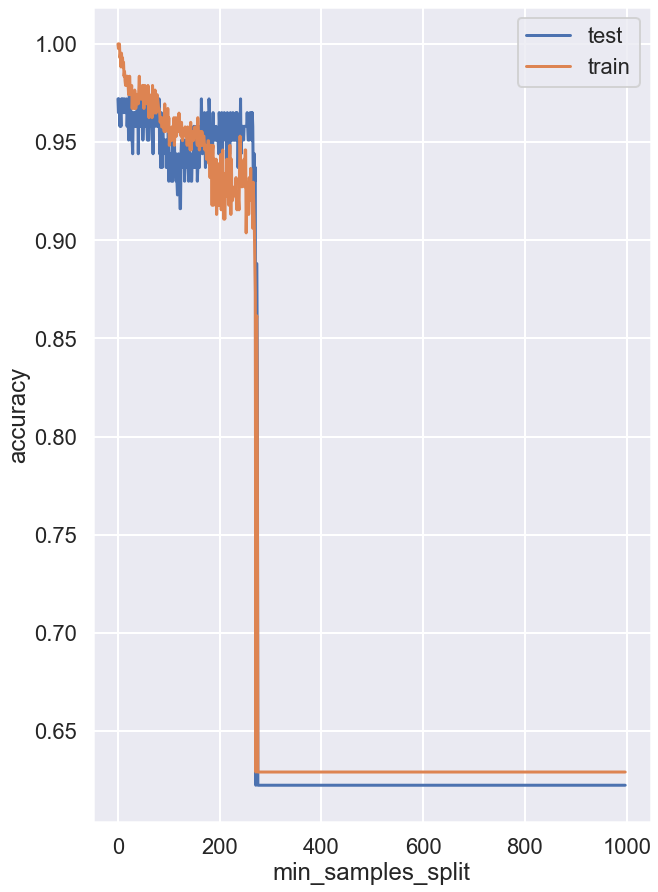

In [29]:
plt.figure(figsize=(10, 15))

accuracy_test = []
accuracy_train = []

for min_samples_split in range(2, 1000):
    model = RandomForestClassifier(n_estimators=25, min_samples_split=min_samples_split)
    model.fit(X_train, y_train)
    predictions_train = model.predict(X_train) 
    predictions_test = model.predict(X_test) 
    accuracy_train.append(accuracy_score(predictions_train, y_train))
    accuracy_test.append(accuracy_score(predictions_test, y_test))

plt.plot(accuracy_test, label='test')
plt.plot(accuracy_train, label='train')
plt.legend()
plt.xlabel('min_samples_split'), plt.ylabel('accuracy')
plt.show()

**Выводы:** ограничивает минимальное количество самплов в узле, чтобы ее можно было разделить, чтобы не делить до одного элемента в каждом листе и не переобучить, с некоторого оптимального значения резко падает, т.к. ограничивает потенциал строящего дерева

**Общие выводы по всей задаче:** случайный лес позволяет строить модели из множества деревьев и усреднять их предсказания, для каждой модели можно регулировать параметры в соответствии с целями, задавать "подробность" дерева.